In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_generate_sample

In [2]:
import warnings

# Ignorar todas las advertencias
warnings.filterwarnings('ignore')

# Aquí va el resto de tu código

from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Ignorar advertencias específicas de convergencia en statsmodels
warnings.filterwarnings('ignore', category=ConvergenceWarning)



## Cargar Datos

### Datos Elkin

In [3]:
z = pd.read_csv('../Data/PIB_real_2000_1_2015_4.txt', header=None, names=["x"])

### Simular Datos

In [4]:
# Simular proeso AR(2)
ar_params = np.array([1, -0.5, -0.3,])# AR parameters = 0.5, 0.4, 0.3 
ma_params = np.array([2])


# Crear el proceso ARMA
ar_object = ArmaProcess(ar_params, ma_params)
n = 1000  # Longitud de la serie de tiempo
datos_simulados = ar_object.generate_sample(nsample=n, scale=1, burnin=100)

df = pd.DataFrame(datos_simulados, columns=['x'])

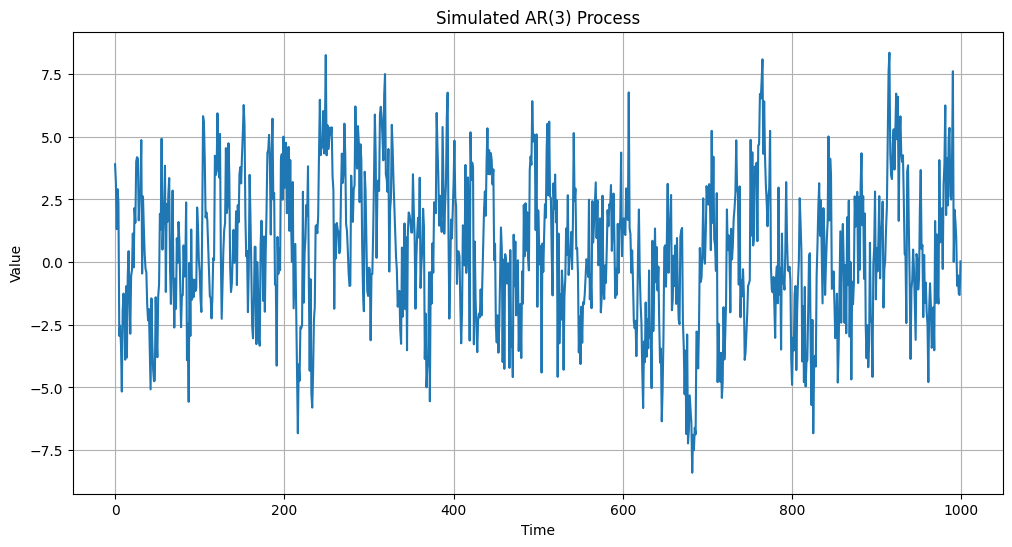

In [4]:
# Graficamos los datos simulados
plt.figure(figsize=(12, 6))
plt.plot(df['z'])
plt.title('Simulated AR(3) Process')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

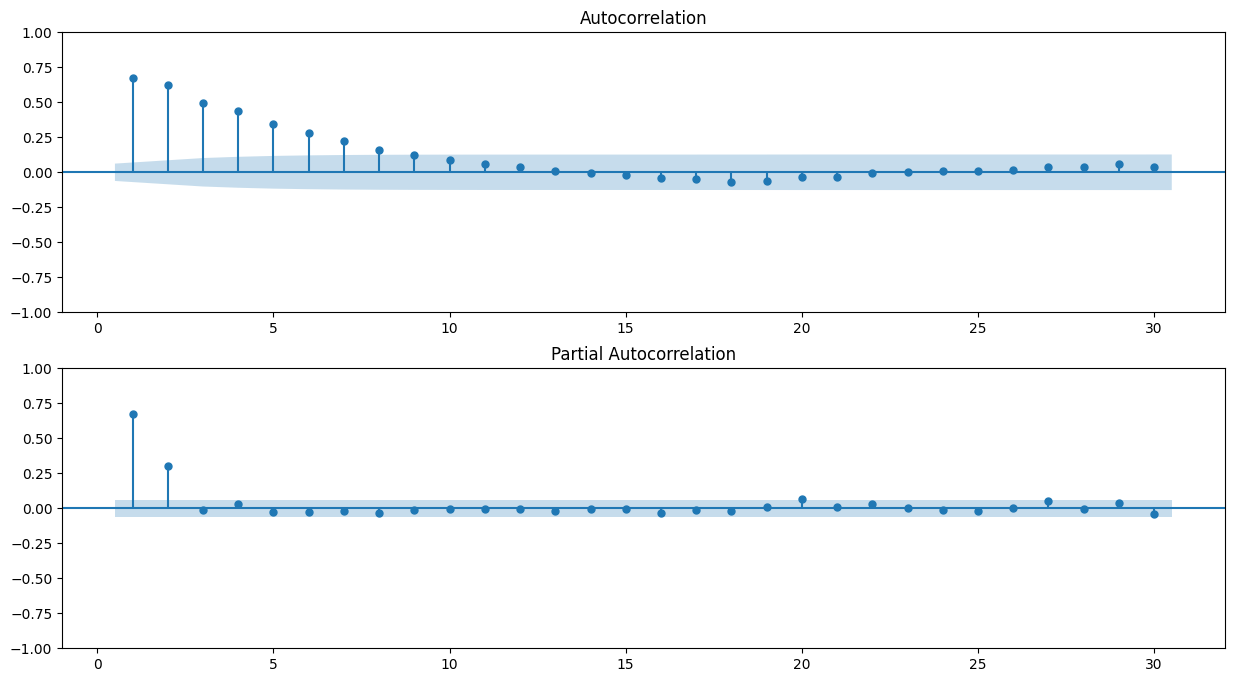

In [5]:
# Correlogramas muestrales para z diferenciada una vez

fig, axs = plt.subplots(2, figsize=(15,8))

# ACF
sm.graphics.tsa.plot_acf(df['z'], ax=axs[0],  alpha=0.05, zero=False)
# PACF
sm.graphics.tsa.plot_pacf(df['z'], ax=axs[1],  alpha=0.05, zero=False)

plt.show()

## ARIMA Grid Search

In [5]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = df
# evaluate parameters
p_values = [0, 1, 2, 4]
d_values = range(0, 2)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=2.978
ARIMA(0, 0, 1) RMSE=2.483
ARIMA(0, 0, 2) RMSE=2.201
ARIMA(0, 1, 0) RMSE=2.246
ARIMA(0, 1, 1) RMSE=2.059
ARIMA(0, 1, 2) RMSE=2.062
ARIMA(1, 0, 0) RMSE=2.083
ARIMA(1, 0, 1) RMSE=2.002
ARIMA(1, 0, 2) RMSE=1.989
ARIMA(1, 1, 0) RMSE=2.059
ARIMA(1, 1, 1) RMSE=2.059
ARIMA(1, 1, 2) RMSE=2.056
ARIMA(2, 0, 0) RMSE=1.984
ARIMA(2, 0, 1) RMSE=1.984
ARIMA(2, 0, 2) RMSE=1.987
ARIMA(2, 1, 0) RMSE=2.059
ARIMA(2, 1, 1) RMSE=1.989
ARIMA(2, 1, 2) RMSE=1.989
ARIMA(4, 0, 0) RMSE=1.987
ARIMA(4, 0, 1) RMSE=1.986
ARIMA(4, 0, 2) RMSE=1.989
ARIMA(4, 1, 0) RMSE=2.043
ARIMA(4, 1, 1) RMSE=1.992
ARIMA(4, 1, 2) RMSE=1.991
Best ARIMA(2, 0, 0) RMSE=1.984


### Para Despues

Combinando con la librería Mango

In [26]:
# Supongamos que ya has cargado tu serie temporal en la variable 'series'
series = df.values

# Función objetivo para la optimización de Mango
def objective(params):
    p = params['p']
    d = params['d']
    q = params['q']
    order = (p, d, q)
    train_size = int(len(series) * 0.66)
    train, test = series[:train_size], series[train_size:]
    history = list(train)
    predictions = []
    
    try:
        for t in range(len(test)):
            model = ARIMA(history, order=order)
            model_fit = model.fit(disp=0)
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test[t])
        rmse = np.sqrt(mean_squared_error(test, predictions))
        return {'objective': rmse}
    except Exception as e:
        print(f'Error with order {order}: {e}')
        return {'objective': float('inf')}  # Return a large number in case of error

# Definición del espacio de parámetros
param_space = {
    'p': range(0, 5),
    'd': range(0, 2),
    'q': range(0, 3)
}

# Configuración del optimizador Mango
tuner = Tuner(param_space, objective)

# Ejecución del proceso de optimización
results = tuner.minimize()

# Resultados
best_params = results['best_params']
best_score = results['best_objective']
print(f'Mejores parámetros encontrados: p={best_params["p"]}, d={best_params["d"]}, q={best_params["q"]}')
print(f'Mejor RMSE encontrado: {best_score:.4f}')



TypeError: list indices must be integers or slices, not str

In [27]:
type(p)

range

In [1]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from mango import scheduler, Tuner

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
def arima_objective_function(args_list):
    global data_values
    
    params_evaluated = []
    results = []
    
    for params in args_list:
        try:
            p,d,q = params['p'],params['d'], params['q']
            trend = params['trend']
            
            model = ARIMA(data_values, order=(p,d,q), trend = trend)
            predictions = model.fit(method='innovations_mle')
            mse = mean_squared_error(data_values, predictions.fittedvalues)   
            params_evaluated.append(params)
            results.append(mse)
        except:
            #print(f"Exception raised for {params}")
            #pass 
            params_evaluated.append(params)
            results.append(1e5)
        
        #print(params_evaluated, mse)
    return params_evaluated, results

param_space = dict(p= range(0, 6),
                   d= range(0, 2),
                   q =range(0, 6),
                   trend = ['n', 'c', 't', 'ct']
                  )

conf_Dict = dict()
conf_Dict['num_iteration'] = 100
data_values = list(df['x'])
tuner = Tuner(param_space, arima_objective_function, conf_Dict)
results = tuner.minimize()

Best score: 3.9990997347158737: 100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


In [29]:
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

best parameters: {'d': 0, 'p': 5, 'q': 4, 'trend': 'c'}
best loss: 3.9990997347158737


In [8]:
a = range(0,2)
a

range(0, 2)

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

In [17]:
class Arima:
    def __init__(self, train_data, p, q, d):
        self.train_data = train_data  # Asegúrate de que train_data es una Serie de pandas.
        self.p = p
        self.q = q
        self.d = d
        self.best_aic = np.Inf
        self.best_bic = np.Inf
        self.best_hqic = np.Inf
        self.best_order = (0, 0, 0)
        self.models = []
        self.model = None

    def is_current_best_model(self):
        no_of_lower_metrics = 0
        if self.model.aic <= self.best_aic:
            no_of_lower_metrics += 1
        if self.model.bic <= self.best_bic:
            no_of_lower_metrics += 1
        if self.model.hqic <= self.best_hqic:
            no_of_lower_metrics += 1
        return no_of_lower_metrics >= 2

    def best_selection(self):
        current_best_model = None
        for p_ in self.p:
            for q_ in self.q:
                current_order = (p_, self.d, q_)
                print("Current Order (p,d,q): " + str(current_order))
                try:
                    self.model = ARIMA(self.train_data, order=current_order).fit(method='innovations_mle')
                    self.models.append(self.model)
                    if self.is_current_best_model():
                        self.best_aic = np.round(self.model.aic, 0)
                        self.best_bic = np.round(self.model.bic, 0)
                        self.best_hqic = np.round(self.model.hqic, 0)
                        self.best_order = current_order
                        current_best_model = self.model
                        print('========================================================================')
                        print("Best model so far: ARIMA" + str(self.best_order) +
                              " AIC:{} BIC:{} HQIC:{}".format(self.best_aic, self.best_bic, self.best_hqic) +
                              " resid:{}".format(np.round(np.exp(self.model.resid).mean(), 3)))
                        print('========================================================================')
                        print()
                except Exception as e:
                    print(f"Failed to fit ARIMA{current_order}: {e}")
                    continue

        if current_best_model:
            print('\n')
            print(current_best_model.summary())
        return current_best_model, self.models


In [81]:
arima_model = Arima(train_data=df['z'], p=range(0, 6), q=range(0, 6), d=range(0,2))


In [82]:
best_model, all_models = arima_model.best_selection()

Current Order (p,d,q): (0, range(0, 2), 0)
Failed to fit ARIMA(0, range(0, 2), 0): '>' not supported between instances of 'range' and 'int'
Current Order (p,d,q): (0, range(0, 2), 1)
Failed to fit ARIMA(0, range(0, 2), 1): '>' not supported between instances of 'range' and 'int'
Current Order (p,d,q): (0, range(0, 2), 2)
Failed to fit ARIMA(0, range(0, 2), 2): '>' not supported between instances of 'range' and 'int'
Current Order (p,d,q): (0, range(0, 2), 3)
Failed to fit ARIMA(0, range(0, 2), 3): '>' not supported between instances of 'range' and 'int'
Current Order (p,d,q): (0, range(0, 2), 4)
Failed to fit ARIMA(0, range(0, 2), 4): '>' not supported between instances of 'range' and 'int'
Current Order (p,d,q): (0, range(0, 2), 5)
Failed to fit ARIMA(0, range(0, 2), 5): '>' not supported between instances of 'range' and 'int'
Current Order (p,d,q): (1, range(0, 2), 0)
Failed to fit ARIMA(1, range(0, 2), 0): '>' not supported between instances of 'range' and 'int'
Current Order (p,d,q

In [83]:
# Imprimir el resumen del mejor modelo
if best_model is not None:
    print("Best Model Summary:")
    print(best_model.summary())
else:
    print("No suitable model was found.")

No suitable model was found.


In [22]:
z

,x
0,70991.0
1,71017.0
2,71421.0
3,71332.0
4,71846.0
...,...
59,130168.0
60,131171.0
61,132204.0
62,133601.0


In [84]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Define los valores para los parámetros d, p, q
d_values = [0, 1]
p_values = [0, 1, 2, 3, 4]
q_values = [0, 1, 2, 3, 4]

# Calcula el número total de modelos
num_modelos = len(d_values) * len(p_values) * len(q_values)
aic = np.full((num_modelos, 4), -99.0)  # Agregamos una columna para 'd'
bic = np.full((num_modelos, 4), -99.0)  # Agregamos una columna para 'd'

# Cargar datos - Asegúrate de que 'df' y la columna 'z' están correctamente definidos
# df = pd.read_csv('tu_archivo.csv')  # Asegúrate de que esta línea esté correctamente configurada

# Modelo y cálculo de AIC y BIC
k = 0
for d in d_values:
    for p in p_values:
        for q in q_values:
            try:
                model = ARIMA(df['z'], order=(p, d, q), trend='t').fit(method='innovations_mle')
                aic[k] = [p, d, q, model.aic]
                bic[k] = [p, d, q, model.bic]
                k += 1
            except Exception as e:
                print(f"No se pudo ajustar el modelo ARIMA({p},{d},{q}): {str(e)}")
                continue

# Convertir a DataFrame
aic_df = pd.DataFrame(aic, columns=['p', 'd', 'q', 'AIC'])
bic_df = pd.DataFrame(bic, columns=['p', 'd', 'q', 'BIC'])

# Ordenar y combinar los resultados
sorted_aic = aic_df.sort_values('AIC')
sorted_bic = bic_df.sort_values('BIC')
combined = pd.concat([sorted_aic.reset_index(drop=True), pd.DataFrame(["     "]*len(sorted_aic), columns=['Separador']), sorted_bic.reset_index(drop=True)], axis=1)

# Mostrar los resultados combinados
print(combined)

# Encontrar los modelos con menor AIC y BIC
best_aic_index = sorted_aic['AIC'].idxmin()
best_bic_index = sorted_bic['BIC'].idxmin()

print(f"Posición del valor mínimo según AIC: {best_aic_index}")
print(f"Posición del valor mínimo según BIC: {best_bic_index}")


      p    d    q          AIC Separador    p    d    q          BIC
0   4.0  0.0  2.0  4228.063048            2.0  0.0  0.0  4248.076598
1   2.0  0.0  0.0  4228.445577            3.0  0.0  0.0  4253.121577
2   3.0  0.0  0.0  4228.582801            2.0  0.0  1.0  4253.298462
3   2.0  0.0  1.0  4228.759685            2.0  1.0  1.0  4255.265657
4   3.0  0.0  4.0  4229.552574            1.0  0.0  2.0  4256.912358
5   1.0  0.0  3.0  4229.988299            1.0  0.0  3.0  4259.434830
6   4.0  1.0  3.0  4230.360081            2.0  0.0  2.0  4259.812213
7   2.0  0.0  2.0  4230.365682            4.0  0.0  0.0  4259.949478
8   2.0  0.0  4.0  4230.449763            3.0  0.0  1.0  4259.996444
9   4.0  0.0  0.0  4230.502946            2.0  1.0  2.0  4260.527979
10  3.0  0.0  1.0  4230.549912            1.0  1.0  3.0  4264.267483
11  2.0  1.0  1.0  4230.731883            3.0  0.0  2.0  4265.331640
12  3.0  0.0  2.0  4230.977353            4.0  0.0  1.0  4265.818750
13  2.0  1.0  2.0  4231.087450    

## Elkin

In [33]:
# Parámetros del modelo
d_values = [0, 1]
p_values = [0, 1, 2, 3, 4]
q_values = [0, 1, 2, 3, 4]
trends = ['n', 'c']  # Diferentes configuraciones para el parámetro "trend"

# Cálculo de número total de modelos basado en el producto de las longitudes de parámetros y tendencias
num_modelos = len(d_values) * len(p_values) * len(q_values) * len(trends)
aic = np.full((num_modelos, 5), None)
bic = np.full((num_modelos, 5), None)

# Asumiendo df['z'] es la serie temporal
k = 0
for trend in trends:
    for d in d_values:
        for p in p_values:
            for q in q_values:
                try:
                    model = ARIMA(df['x'], order=(p, d, q), trend=trend).fit(method='innovations_mle')
                    aic[k] = [p, d, q, trend, model.aic]
                    bic[k] = [p, d, q, trend, model.bic]
                    k += 1
                except Exception as e:
                    print(f"No se pudo ajustar el modelo ARIMA({p},{d},{q},{trend}): {str(e)}")
                    continue

# Convertir a DataFrame
aic_df = pd.DataFrame(aic, columns=['p', 'd', 'q', 'trend', 'AIC'])
bic_df = pd.DataFrame(bic, columns=['p', 'd', 'q', 'trend', 'BIC'])

# Ordenar y obtener los tres mejores modelos según AIC y BIC
sorted_aic = aic_df.sort_values('AIC').head(3)
sorted_bic = bic_df.sort_values('BIC').head(3)

# Mostrar los resultados
print("Los tres mejores modelos según AIC:")
print(sorted_aic)
print("\nLos tres mejores modelos según BIC:")
print(sorted_bic)


No se pudo ajustar el modelo ARIMA(0,1,0,c): In models with integration (`d > 0`) or seasonal integration (`D > 0`), trend terms of lower order than `d + D` cannot be (as they would be eliminated due to the differencing operation). For example, a constant cannot be included in an ARIMA(1, 1, 1) model, but including a linear trend, which would have the same effect as fitting a constant to the differenced data, is allowed.
No se pudo ajustar el modelo ARIMA(0,1,1,c): In models with integration (`d > 0`) or seasonal integration (`D > 0`), trend terms of lower order than `d + D` cannot be (as they would be eliminated due to the differencing operation). For example, a constant cannot be included in an ARIMA(1, 1, 1) model, but including a linear trend, which would have the same effect as fitting a constant to the differenced data, is allowed.
No se pudo ajustar el modelo ARIMA(0,1,2,c): In models with integration (`d > 0`) or seasonal integration (`D > 0`), trend terms of lower order than `

## Web

In [34]:
class Arima:
    def __init__(self, train_data, p_values, d_values, q_values, trends):
        self.train_data = train_data  # Asegúrate de que train_data es una Serie de pandas.
        self.p_values = p_values
        self.d_values = d_values
        self.q_values = q_values
        self.trends = trends
        self.best_aic = np.Inf
        self.best_bic = np.Inf
        self.best_hqic = np.Inf
        self.best_order = (0, 0, 0, '')
        self.models = []
        self.model = None

    def is_current_best_model(self):
        no_of_lower_metrics = 0
        if self.model.aic <= self.best_aic:
            no_of_lower_metrics += 1
        if self.model.bic <= self.best_bic:
            no_of_lower_metrics += 1
        if hasattr(self.model, 'hqic') and self.model.hqic <= self.best_hqic:  # Ensure hqic exists
            no_of_lower_metrics += 1
        return no_of_lower_metrics >= 2

    def best_selection(self):
        current_best_model = None
        for trend in self.trends:
            for d in self.d_values:
                for p in self.p_values:
                    for q in self.q_values:
                        current_order = (p, d, q)
                        try:
                            self.model = ARIMA(self.train_data, order=current_order, trend=trend).fit(method='innovations_mle')
                            self.models.append((current_order, trend, self.model))
                            if self.is_current_best_model():
                                self.best_aic = np.round(self.model.aic, 0)
                                self.best_bic = np.round(self.model.bic, 0)
                                self.best_hqic = np.round(self.model.hqic, 0) if hasattr(self.model, 'hqic') else np.Inf
                                self.best_order = (p, d, q, trend)
                                current_best_model = self.model
                                print('========================================================================')
                                print("Best model so far: ARIMA" + str(self.best_order) +
                                      " AIC:{} BIC:{} HQIC:{}".format(self.best_aic, self.best_bic, self.best_hqic) +
                                      " resid:{}".format(np.round(np.exp(self.model.resid).mean(), 3)))
                                print('========================================================================')
                                print()
                        except Exception as e:
                            print(f"Failed to fit ARIMA{current_order} with trend '{trend}': {e}")
                            continue

        if current_best_model:
            print('\n')
            print(current_best_model.summary())
        return current_best_model, self.models


In [35]:
# Asumir que la clase Arima ha sido definida o importada correctamente desde otro módulo si es necesario
# from your_module import Arima  # Descomentar si la clase está en otro módulo

# Definir los rangos de los parámetros y las tendencias
p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1]
q_values = [0, 1, 2, 3, 4, 5]
trends = ['n']

# Instanciar la clase Arima con la serie temporal
arima = Arima(train_data=df['x'], p_values=p_values, d_values=d_values, q_values=q_values, trends=trends)

# Encontrar y mostrar los mejores modelos
best_model, all_models = arima.best_selection()

# Imprimir resumen del mejor modelo encontrado
if best_model is not None:
    print("Mejor Modelo:")
    print(best_model.summary())
else:
    print("No se encontró un modelo adecuado.")


Best model so far: ARIMA(0, 0, 0, 'n') AIC:4978.0 BIC:4983.0 HQIC:4980.0 resid:60.781

Best model so far: ARIMA(0, 0, 1, 'n') AIC:4651.0 BIC:4660.0 HQIC:4654.0 resid:20.367

Best model so far: ARIMA(0, 0, 2, 'n') AIC:4416.0 BIC:4430.0 HQIC:4421.0 resid:12.188

Best model so far: ARIMA(0, 0, 3, 'n') AIC:4331.0 BIC:4351.0 HQIC:4338.0 resid:10.924

Best model so far: ARIMA(0, 0, 4, 'n') AIC:4308.0 BIC:4333.0 HQIC:4317.0 resid:10.328

Best model so far: ARIMA(0, 0, 5, 'n') AIC:4283.0 BIC:4313.0 HQIC:4294.0 resid:9.6

Best model so far: ARIMA(1, 0, 1, 'n') AIC:4272.0 BIC:4286.0 HQIC:4277.0 resid:8.733

Best model so far: ARIMA(1, 0, 2, 'n') AIC:4250.0 BIC:4269.0 HQIC:4257.0 resid:8.738

Best model so far: ARIMA(1, 0, 3, 'n') AIC:4246.0 BIC:4271.0 HQIC:4255.0 resid:8.623

Best model so far: ARIMA(2, 0, 0, 'n') AIC:4249.0 BIC:4263.0 HQIC:4254.0 resid:8.497



                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations

In [36]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import heapq

class Arima:
    def __init__(self, train_data, p_values, d_values, q_values, trends):
        self.train_data = train_data
        self.p_values = p_values
        self.d_values = d_values
        self.q_values = q_values
        self.trends = trends
        self.best_models_aic = []
        self.best_models_bic = []
        self.best_models_hqic = []

    def best_selection(self):
        for trend in self.trends:
            for d in self.d_values:
                for p in self.p_values:
                    for q in self.q_values:
                        try:
                            model = ARIMA(self.train_data, order=(p, d, q), trend=trend).fit()
                            model_info = (model.aic, model.bic, getattr(model, 'hqic', np.inf), (p, d, q, trend), model)

                            # Update best models for AIC
                            if len(self.best_models_aic) < 3:
                                heapq.heappush(self.best_models_aic, (-model_info[0], model_info))
                            else:
                                heapq.heappushpop(self.best_models_aic, (-model_info[0], model_info))

                            # Update best models for BIC
                            if len(self.best_models_bic) < 3:
                                heapq.heappush(self.best_models_bic, (-model_info[1], model_info))
                            else:
                                heapq.heappushpop(self.best_models_bic, (-model_info[1], model_info))

                            # Update best models for HQIC
                            if hasattr(model, 'hqic'):
                                if len(self.best_models_hqic) < 3:
                                    heapq.heappush(self.best_models_hqic, (-model_info[2], model_info))
                                else:
                                    heapq.heappushpop(self.best_models_hqic, (-model_info[2], model_info))

                        except Exception as e:
                            print(f"Failed to fit ARIMA{p,d,q} with trend '{trend}': {e}")
                            continue

        # Return the top 3 models by each criterion
        best_aic_models = sorted([info for _, info in self.best_models_aic], reverse=True, key=lambda x: x[0])
        best_bic_models = sorted([info for _, info in self.best_models_bic], reverse=True, key=lambda x: x[1])
        best_hqic_models = sorted([info for _, info in self.best_models_hqic], reverse=True, key=lambda x: x[2]) if self.best_models_hqic else []

        return best_aic_models, best_bic_models, best_hqic_models



In [37]:
# Uso de la clase:
# Asumir que df es tu DataFrame y 'z' es la columna que contiene los datos de la serie temporal
p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1]
q_values = [0, 1, 2, 3, 4, 5]
trends = ['n' ,'c']
arima = Arima(train_data=df['x'], p_values=p_values, d_values=d_values, q_values=q_values, trends=trends)
best_aic_models, best_bic_models, best_hqic_models = arima.best_selection()

# Mostrar los mejores modelos:
print("Top 3 Models by AIC:")
for model in best_aic_models:
    print(f"ARIMA{model[3]}: AIC = {model[0]}")

print("\nTop 3 Models by BIC:")
for model in best_bic_models:
    print(f"ARIMA{model[3]}: BIC = {model[1]}")

if best_hqic_models:
    print("\nTop 3 Models by HQIC:")
    for model in best_hqic_models:
        print(f"ARIMA{model[3]}: HQIC = {model[2]}")

Failed to fit ARIMA(0, 1, 0) with trend 'c': In models with integration (`d > 0`) or seasonal integration (`D > 0`), trend terms of lower order than `d + D` cannot be (as they would be eliminated due to the differencing operation). For example, a constant cannot be included in an ARIMA(1, 1, 1) model, but including a linear trend, which would have the same effect as fitting a constant to the differenced data, is allowed.
Failed to fit ARIMA(0, 1, 1) with trend 'c': In models with integration (`d > 0`) or seasonal integration (`D > 0`), trend terms of lower order than `d + D` cannot be (as they would be eliminated due to the differencing operation). For example, a constant cannot be included in an ARIMA(1, 1, 1) model, but including a linear trend, which would have the same effect as fitting a constant to the differenced data, is allowed.
Failed to fit ARIMA(0, 1, 2) with trend 'c': In models with integration (`d > 0`) or seasonal integration (`D > 0`), trend terms of lower order than `

In [95]:
z

,x
0,70991.0
1,71017.0
2,71421.0
3,71332.0
4,71846.0
...,...
59,130168.0
60,131171.0
61,132204.0
62,133601.0
